# Introduction

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
import seaborn as sns

## Import dataset

In [2]:
%%time
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')

CPU times: user 572 ms, sys: 2.04 s, total: 2.61 s
Wall time: 16.1 s


In [3]:
train.head()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


In [4]:
obs = train.shape[0]
print(f"number of observations: {obs}")

number of observations: 3141410


In [5]:
time_steps, assets = train.time_id.nunique(), train.investment_id.nunique()
print(f"number of assets: {assets} \t time steps: {time_steps}")

number of assets: 3579 	 time steps: 1211


In [6]:
print(f"number of assets: {assets} (range from {train.investment_id.min()} to {train.investment_id.max()})")

number of assets: 3579 (range from 0 to 3773)


## Target analysis

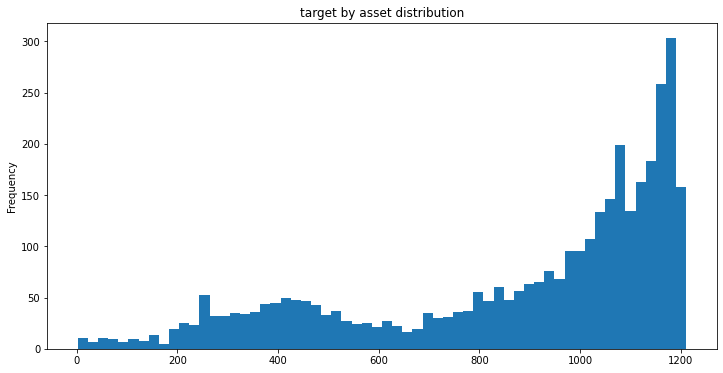

In [7]:
obs_by_asset = train.groupby(['investment_id'])['target'].count()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
obs_by_asset.plot.hist(bins=60)
plt.title("target by asset distribution")
plt.show()

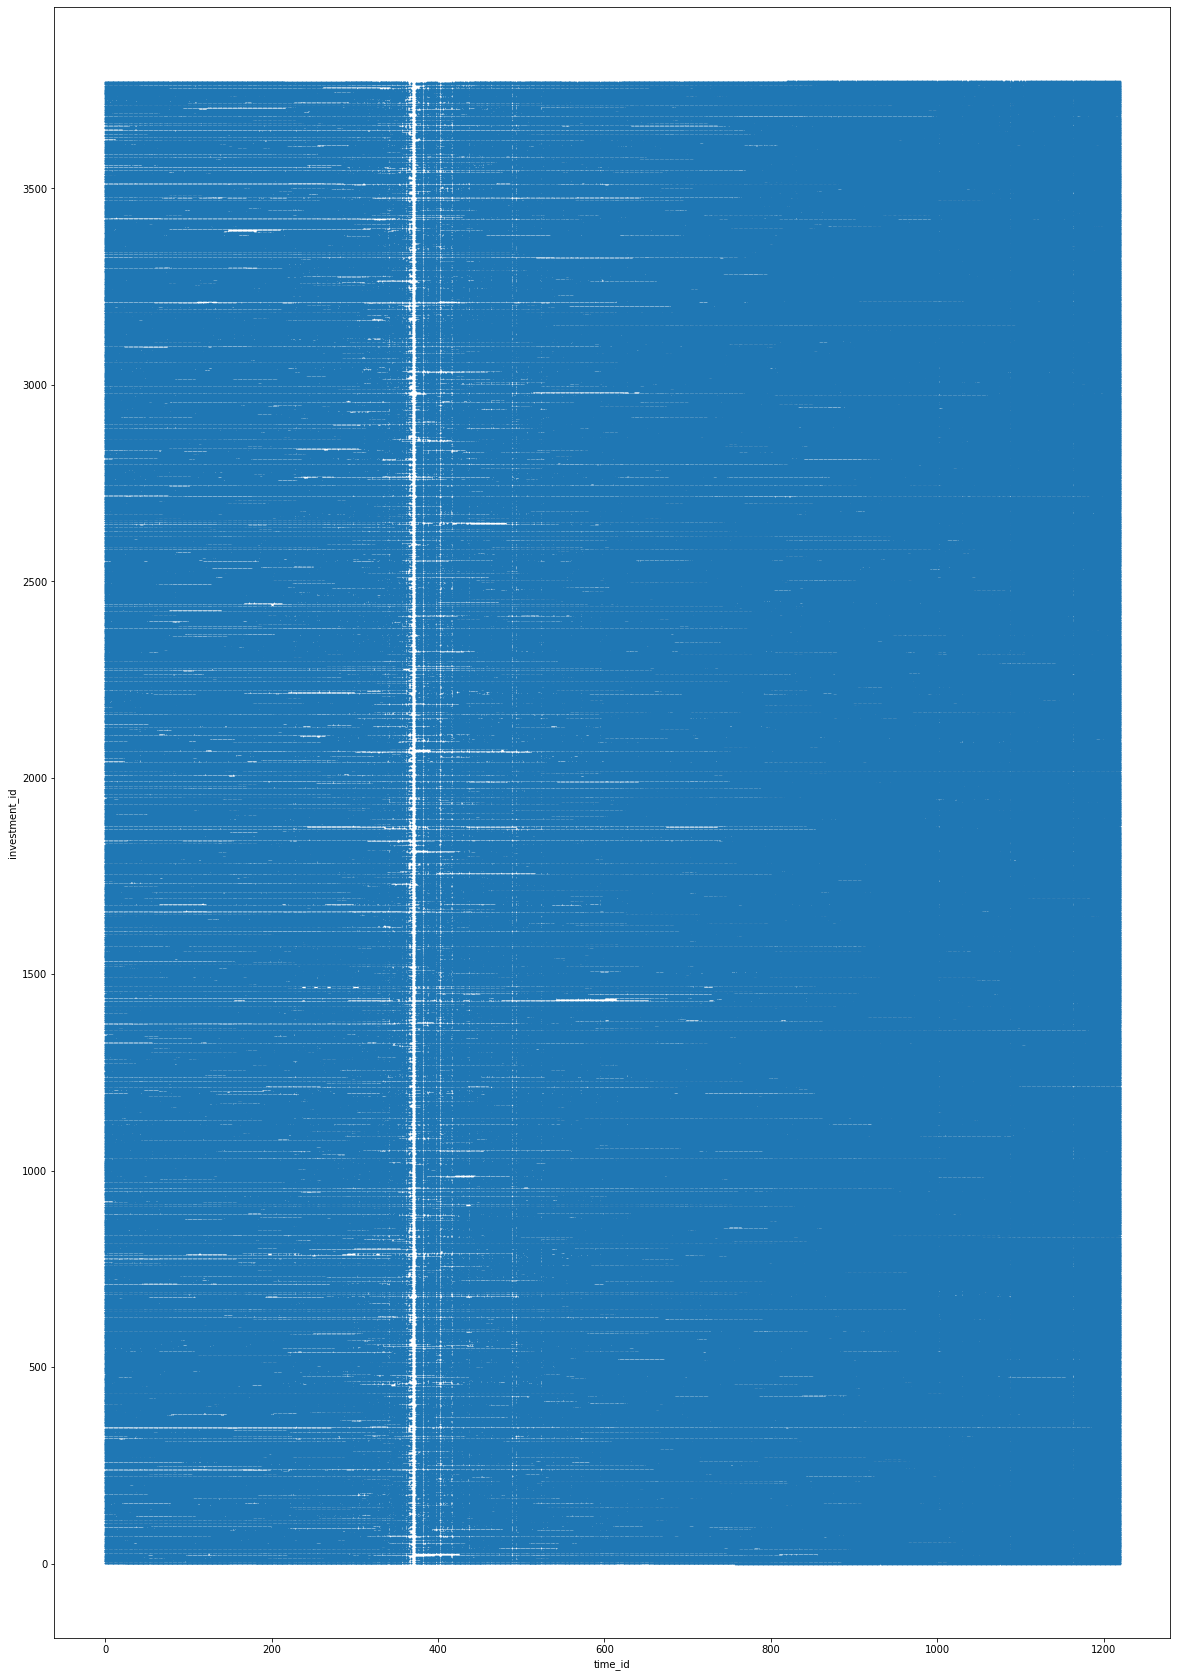

In [8]:
train[['investment_id', 'time_id']].plot.scatter('time_id', 'investment_id', figsize=(20, 30), s=0.5)
plt.show()

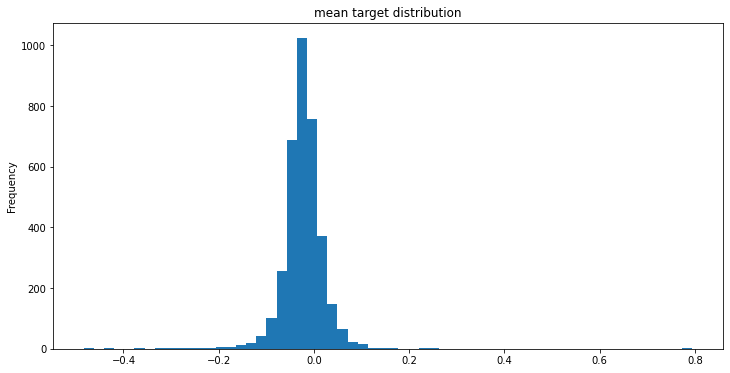

Mean of mean target: -0.02310


In [9]:
mean_target = train.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
mean_target.plot.hist(bins=60)
plt.title("mean target distribution")
plt.show()

print(f"Mean of mean target: {mean_mean_target: 0.5f}")

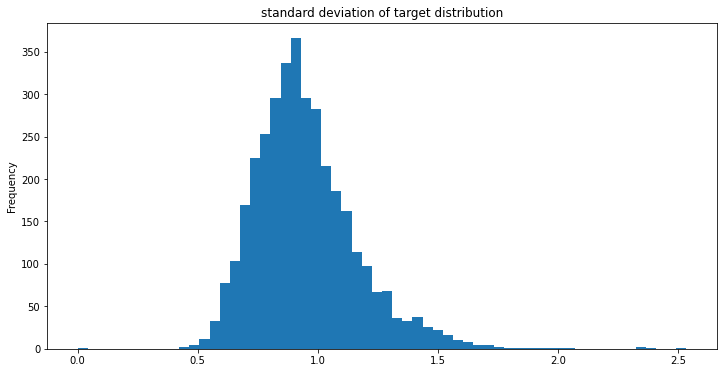

Mean of std target:  0.94790


In [10]:
sts_target = train.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(sts_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sts_target.plot.hist(bins=60)
plt.title("standard deviation of target distribution")
plt.show()

print(f"Mean of std target: {mean_std_target: 0.5f}")

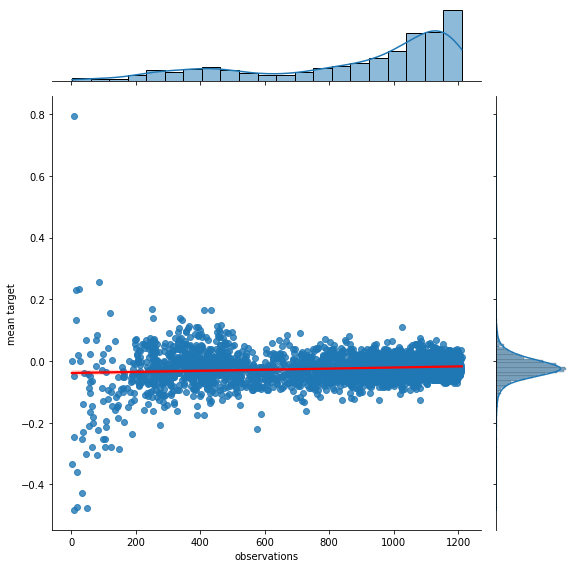

In [11]:
ax = sns.jointplot(x=obs_by_asset, y=mean_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('mean target')
plt.show()

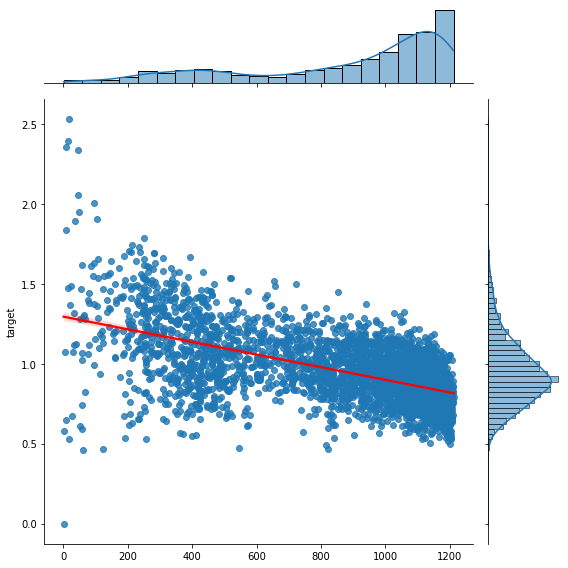

In [12]:
qx = sns.jointplot(x=obs_by_asset.values, y=sts_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('std target')
plt.show()

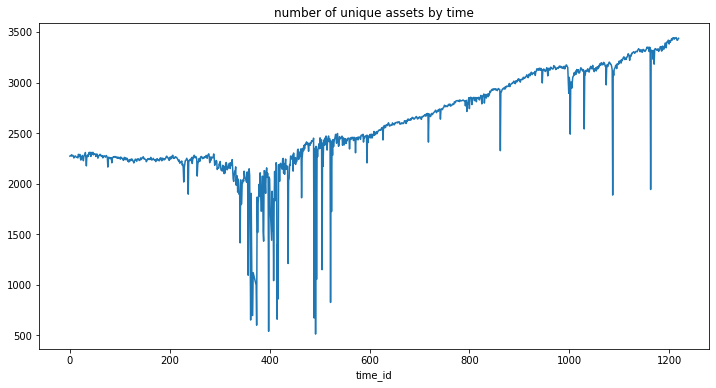

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
train.groupby('time_id')['investment_id'].nunique().plot()
plt.title("number of unique assets by time")
plt.show()

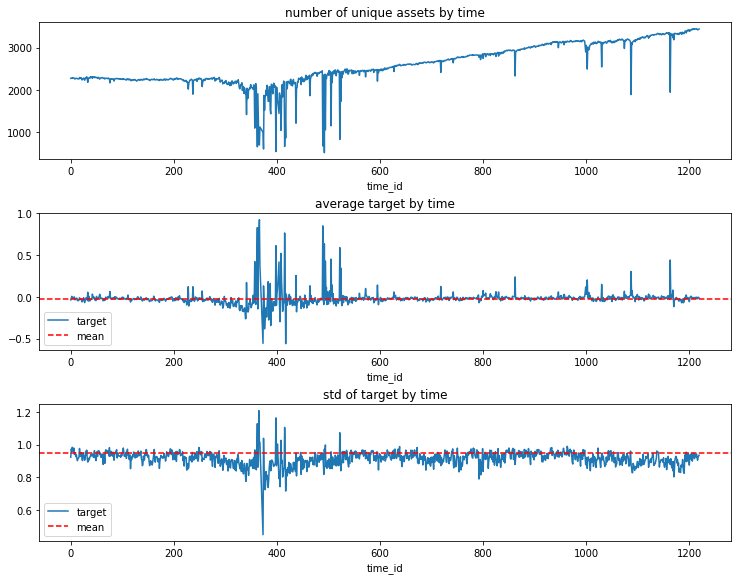

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1,)
(train.groupby('time_id')['investment_id'].nunique()).plot()
plt.title("number of unique assets by time")

plt.subplot(3, 1, 2)
train.groupby('time_id')['target'].mean().plot()
plt.title("average target by time")
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplot(3, 1, 3)
train.groupby('time_id')['target'].std().plot()
plt.title("std of target by time")
plt.axhline(y=mean_std_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [15]:
r = np.corrcoef(train.groupby('time_id')['investment_id'].nunique(), train.groupby('time_id')['target'].mean())[0][1]
print(f"Correlation of number of assets by target: {r:0.3f}")

Correlation of number of assets by target: -0.184


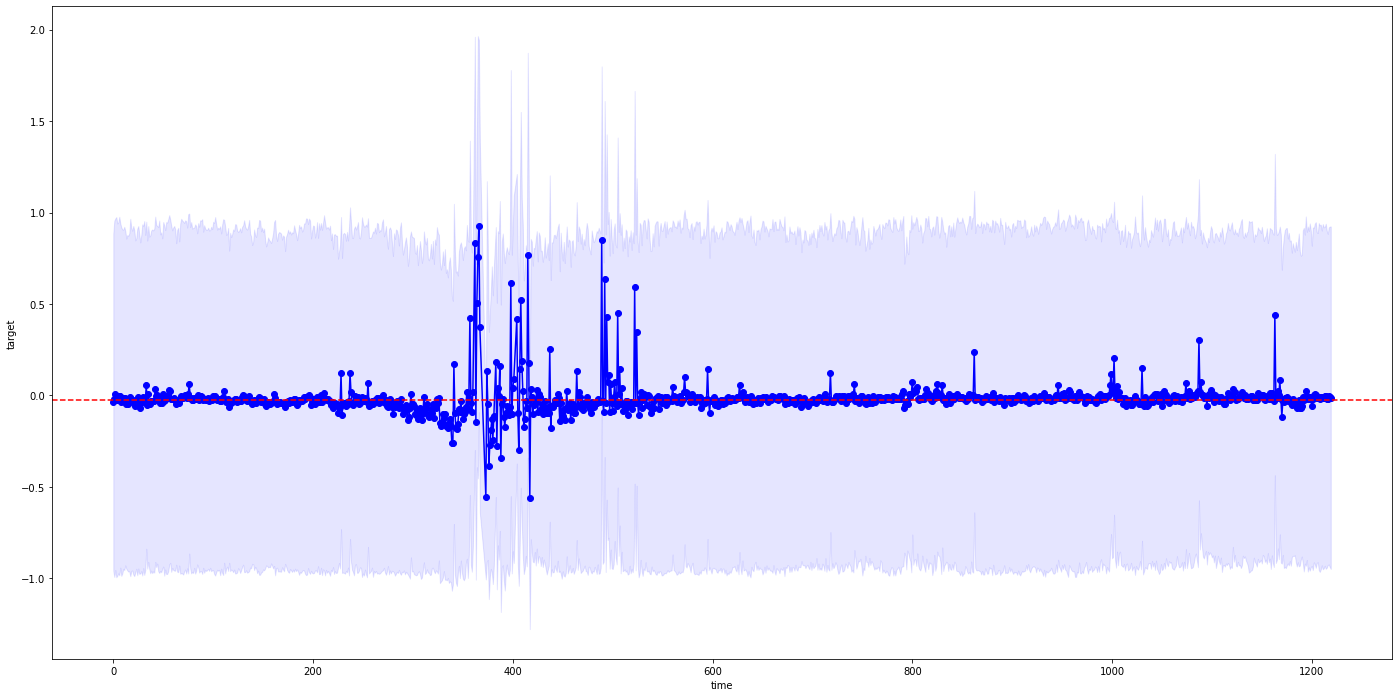

In [16]:
time2target_mean = train.groupby(['time_id'])['target'].mean()
time2target_std = train.groupby(['time_id'])['target'].std()

_, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )
plt.plot(
        time2target_mean.index, time2target_mean, "o-", color="b", label="Training score"
    )
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")
axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

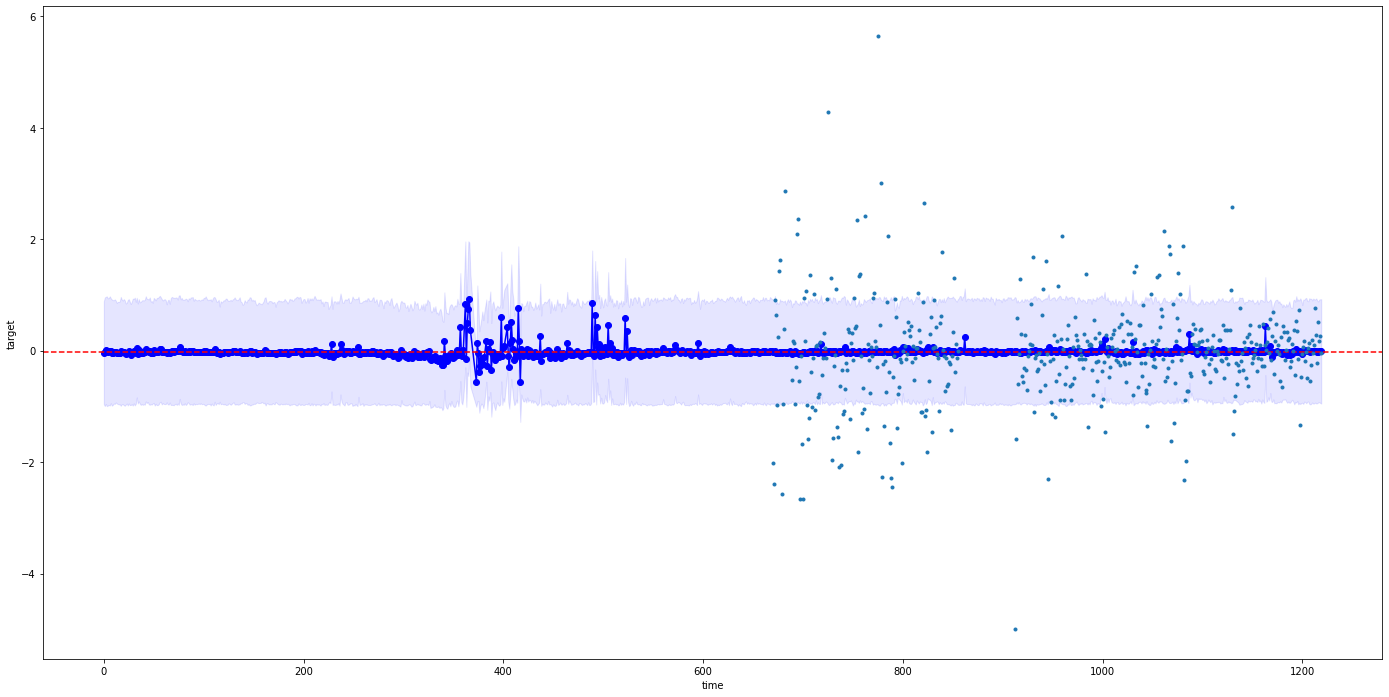

In [17]:
time2target_mean = train.groupby(['time_id'])['target'].mean()
time2target_std = train.groupby(['time_id'])['target'].std()

_, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )
plt.plot(
        time2target_mean.index, time2target_mean, "o-", color="b", label="Training score"
    )
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")

asset = 70
plt.plot(train[train.investment_id==asset].time_id,
               train[train.investment_id==asset].target, '.')

axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

## Count of obs by asset based on the features

In [18]:
# obs_by_asset = train.groupby(['investment_id'])['target'].count().to_dict()
# target = train.investment_id.copy().replace(obs_by_asset).astype(np.int16)
# features = train.columns[4:]

# del(obs_by_asset)

In [19]:
# corrs = list()
# for col in features:
#     corr = np.corrcoef(target, train[col])[0][1]
#     corrs.append(corr)
    
# del(target)

In [20]:
# feat_importances = pd.Series(corrs, index=features)
# feat_importances.nlargest(20).plot(kind='barh', figsize=(12, 6)).invert_yaxis()
# plt.show()

## Post EDA

In [21]:
investment_id = train.pop("investment_id")
investment_id.head()

0    1
1    2
2    6
3    7
4    8
Name: investment_id, dtype: uint16

In [22]:
_ = train.pop("time_id")

In [23]:
y = train.pop("target")
y.head()

0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

## Create a IntegerLookup layer for investment_id input

In [24]:
%%time
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

CPU times: user 233 ms, sys: 23.6 ms, total: 256 ms
Wall time: 406 ms


## Make Tensorflow dataset

In [25]:
import tensorflow as tf
def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## Modeling

In [26]:
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

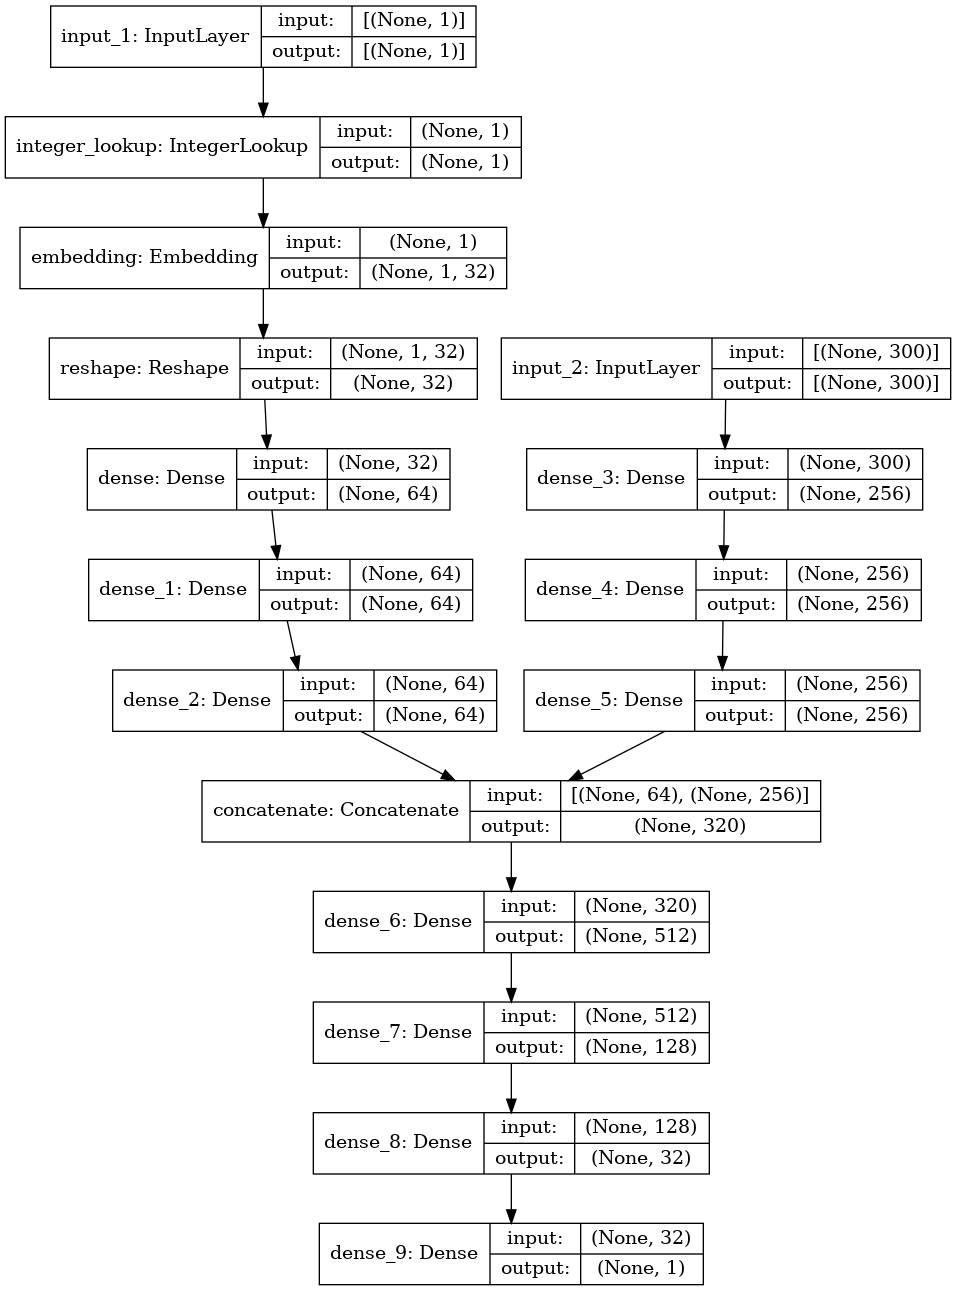

In [27]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/30
2455/2455 [==============================] - 112s 45ms/step - loss: 0.9103 - mse: 0.8314 - mae: 0.6243 - mape: 118768.1328 - rmse: 0.9118 - val_loss: 0.8402 - val_mse: 0.8389 - val_mae: 0.6296 - val_mape: 172772.9844 - val_rmse: 0.9159


2022-02-27 19:52:47.145065: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/30
2455/2455 [==============================] - 94s 38ms/step - loss: 0.8309 - mse: 0.8274 - mae: 0.6230 - mape: 143759.4375 - rmse: 0.9096 - val_loss: 0.8402 - val_mse: 0.8385 - val_mae: 0.6309 - val_mape: 149431.4062 - val_rmse: 0.9157
Epoch 3/30
2455/2455 [==============================] - 96s 39ms/step - loss: 0.8290 - mse: 0.8245 - mae: 0.6218 - mape: 146823.1719 - rmse: 0.9080 - val_loss: 0.8413 - val_mse: 0.8383 - val_mae: 0.6305 - val_mape: 157117.4844 - val_rmse: 0.9156
Epoch 4/30
2455/2455 [==============================] - 96s 39ms/step - loss: 0.8276 - mse: 0.8217 - mae: 0.6207 - mape: 149761.3906 - rmse: 0.9065 - val_loss: 0.8385 - val_mse: 0.8369 - val_mae: 0.6284 - val_mape: 167279.3125 - val_rmse: 0.9148
Epoch 5/30
2455/2455 [==============================] - 97s 39ms/step - loss: 0.8259 - mse: 0.8190 - mae: 0.6196 - mape: 148927.0938 - rmse: 0.9050 - val_loss: 0.8388 - val_mse: 0.8367 - val_mae: 0.6292 - val_mape: 143058.9531 - val_rmse: 0.9147
Epoch 6/30
2455/

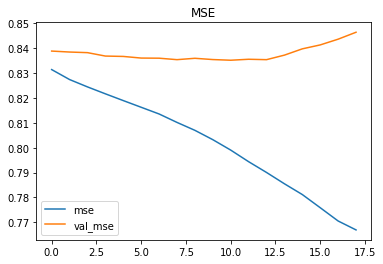

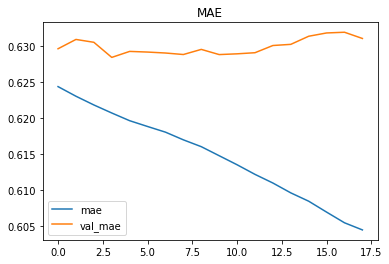

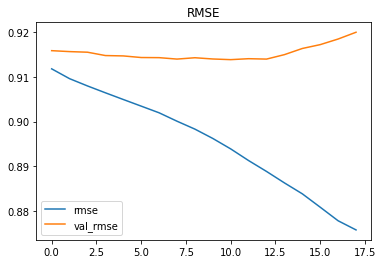

CPU times: user 1h 27min 40s, sys: 4min 19s, total: 1h 32min
Wall time: 35min 22s


In [28]:
%%time
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    model = keras.models.load_model(f"model_{index}")
    models.append(model)
    
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    break

## Submission

In [29]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [30]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
